In [1]:
import pandas as pd
import numpy as np
import sqlite3
import argparse

In [2]:

sensor_list = ['foundation_origin xy FloaterOffset [m]',
               'foundation_origin Rxy FloaterTilt [deg]',
               'foundation_origin Rz FloaterYaw [deg]',
               'foundation_origin z FloaterHeave [m]',
               'foundation_origin Mooring GXY Resultant force [kN]',
               'MooringLine1 Effective tension Fairlead [kN]',
               'MooringLine2 Effective tension Fairlead [kN]',
               'MooringLine3 Effective tension Fairlead [kN]',
               'MooringLine4 Effective tension Fairlead [kN]',
               'MooringLine5 Effective tension Fairlead [kN]',
               'GE14-220 GXY acceleration [m/s^2]',
               'CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m]',
]

feature_list = ['WindGeographic',
                'Uhub',
                'WaveGeographic',
                'Hs',
                'YawError',
                'Tp',
                'CurrentGeographic',
                'CurrentSpeed',
]

In [3]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [4]:
# NEWNEWNEW
def get_absolute(data, col):
    data_abs = data.copy()
    data_abs[col] = data_abs[col].abs()
    return data_abs

def get_reverse(data, col):
    data_rev = data.copy()
    data_rev[col] = -data_rev[col]
    return data_rev

In [5]:
db = 'U62_PULSE_simulationstats.db'
con = sqlite3.connect(db)
df_sensors = pd.read_sql_query('SELECT * FROM sensors', con)
df_stats = pd.read_sql_query('SELECT * FROM standardstatistics', con)
df_simAttr = pd.read_sql_query('SELECT * FROM simulationattributes', con)
con.close()

In [9]:
df_sensors.to_csv('sensors.csv', index=False)

In [6]:
# groups of simulations (different seeds)
groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'].set_index('simulation_id') #get groupID for each simulation
groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'] #get groupID for each simulation
groups = groups.rename(columns={'value':'GroupID'})[['simulation_id', 'GroupID']].astype(int) #rename and convert to int

# filter simulation results
sensors = df_sensors[df_sensors['name'].isin(sensor_list)] #filter 2348 sensors for 12
sim_results = df_stats[df_stats['sensor_id'].isin(sensors['id'].unique())] #filter results of 2348 sensors for 12
sim_results = sim_results.pivot(index='simulation_id', columns='sensor_id', values='max').sort_index()
sim_results = sim_results.merge(groups, on='simulation_id').set_index('simulation_id') #join groups with sim_results on simulation_id

# filter simulation attributes
df_simAttr_filter = df_simAttr[df_simAttr['name'].isin(feature_list)] #filter 47 simulation attributes for 8
caselist = df_simAttr_filter.pivot(index='simulation_id', columns='name', values='value') #pivot to get 1 row per simulation
caselist = caselist.merge(groups, on='simulation_id').set_index('simulation_id') #join groups and caselist on simulation_id

# find simulations that do not have results and filter them out
common_indices = caselist.index.intersection(sim_results.index)
filtered_caselist = caselist.loc[common_indices] # filter the caselist to only include simulations with results
sim_results = sim_results.loc[common_indices] # just to make sure there are no ouputs without x values
print(f'Deleted {len(caselist) - len(filtered_caselist)} simulations with missing output data.')
print(f"Indices: {[index for index in caselist.loc[~caselist.index.isin(common_indices)].index]}")

# only returning one result per groupID
mean_results = sim_results.groupby('GroupID').mean().reset_index()
caselist_unique = caselist.groupby(caselist['GroupID']).first().reset_index()

# change the data types
caselist_unique[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError', 'GroupID']] = caselist_unique[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError', 'GroupID']].astype(int)
caselist_unique[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']] = caselist_unique[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']].astype(float)

# encode the cyclical features
caselist_unique = encode(caselist_unique, 'CurrentGeographic', 360)
caselist_unique = encode(caselist_unique, 'WaveGeographic', 360)
caselist_unique = encode(caselist_unique, 'WindGeographic', 360)
caselist_unique = encode(caselist_unique, 'YawError', 360)

# NEWNEWNEW
mean_results = get_absolute(mean_results, 49) #49: foundation_origin z FloaterHeave [m]
mean_results = get_absolute(mean_results, 52) #52 foundation_origin Rz FloaterYaw [deg]

# drop the original columns
caselist_unique = caselist_unique.drop(columns=['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError'])

# rename the columns of sim_results
# column_mapping = pd.Series(sensors.name.values,index=sensors.id).to_dict()
# mean_results = mean_results.rename(columns=column_mapping)

# drop groupID col from both dataframes
caselist_unique = caselist_unique.drop(columns=['GroupID'])
mean_results = mean_results.drop(columns=['GroupID'])

Deleted 1 simulations with missing output data.
Indices: [5333]


In [7]:
sensors

,id,name
48,49,foundation_origin z FloaterHeave [m]
51,52,foundation_origin Rz FloaterYaw [deg]
58,59,foundation_origin xy FloaterOffset [m]
59,60,foundation_origin Rxy FloaterTilt [deg]
163,164,CEN_E3 Resultant bending moment ArcLength=2.72...
1476,1477,MooringLine1 Effective tension Fairlead [kN]
1492,1493,MooringLine2 Effective tension Fairlead [kN]
1508,1509,MooringLine3 Effective tension Fairlead [kN]
1524,1525,MooringLine4 Effective tension Fairlead [kN]
1540,1541,MooringLine5 Effective tension Fairlead [kN]


In [7]:
mean_results

,49,52,59,60,164,1477,1493,1509,1525,1541,1563,2348
0,3.641690,4.744566,28.170541,3.859987,545223.568598,2636.376628,1868.182861,1989.452026,7698.197428,3596.053141,8098.622960,3.077109
1,4.545901,0.898652,28.771844,3.731182,521949.626362,2482.106527,1807.729451,1872.254435,7625.719238,3408.941895,8005.953332,2.670720
2,4.469769,2.031366,28.347607,3.974630,468036.635680,2412.833089,1768.106242,1949.155070,7771.525553,3327.807617,7767.606475,2.386209
3,2.716954,3.469070,30.397904,5.759532,729098.671590,3178.914958,2286.855794,1588.076945,7976.302083,4396.402425,9343.292493,3.339900
4,3.477001,0.073924,31.109725,6.270891,692740.416184,2870.001872,2079.517619,1572.595052,7910.671875,3925.814616,8918.474094,2.682204
...,...,...,...,...,...,...,...,...,...,...,...,...
1885,3.733195,0.211397,30.515850,5.953782,689354.894901,2570.507243,1856.260457,1541.321940,8390.021647,3616.480713,8567.465780,2.743143
1886,3.620160,0.315077,30.937133,6.180584,652888.200837,2521.273600,1842.511149,1629.399048,8902.977702,3620.156576,8829.969652,2.592859
1887,3.199350,4.394077,29.675553,4.675129,608159.687689,2588.397868,1788.564575,1931.185343,8645.094564,3698.596680,8774.859798,2.986340
1888,4.028750,1.888455,26.861148,5.036097,583012.811339,2411.850830,1728.675659,1802.109619,7313.997559,3346.949300,7449.177783,2.655583


In [8]:
caselist_unique

,CurrentSpeed,Hs,Tp,Uhub,CurrentGeographic_sin,CurrentGeographic_cos,WaveGeographic_sin,WaveGeographic_cos,WindGeographic_sin,WindGeographic_cos,YawError_sin,YawError_cos
0,0.97,11.8,13.05,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
1,0.97,11.8,14.50,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
2,0.97,11.8,15.95,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
3,0.97,11.8,13.05,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
4,0.97,11.8,14.50,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1.17,11.8,14.50,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1886,1.17,11.8,15.95,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1887,1.17,11.8,13.05,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000
1888,1.17,11.8,14.50,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000


In [9]:
sensors

,id,name
48,49,foundation_origin z FloaterHeave [m]
51,52,foundation_origin Rz FloaterYaw [deg]
58,59,foundation_origin xy FloaterOffset [m]
59,60,foundation_origin Rxy FloaterTilt [deg]
163,164,CEN_E3 Resultant bending moment ArcLength=2.72...
1476,1477,MooringLine1 Effective tension Fairlead [kN]
1492,1493,MooringLine2 Effective tension Fairlead [kN]
1508,1509,MooringLine3 Effective tension Fairlead [kN]
1524,1525,MooringLine4 Effective tension Fairlead [kN]
1540,1541,MooringLine5 Effective tension Fairlead [kN]


In [10]:
for sensor_id, sensor_name in zip(sensors['id'], sensors['name']):
    min_value = mean_results[sensor_id].min()
    max_value = mean_results[sensor_id].max()
    mean_value = mean_results[sensor_id].mean()
    print(f"Sensor: {sensor_name}")
    print(f"Minimum Value: {min_value}")
    print(f"Maximum Value: {max_value}")
    print(f"Mean Value: {mean_value}")

Sensor: foundation_origin z FloaterHeave [m]
Minimum Value: 0.00611525463561217
Maximum Value: 5.9761308034261065
Mean Value: 2.356079881674486
Sensor: foundation_origin Rz FloaterYaw [deg]
Minimum Value: 0.0008914555797890367
Maximum Value: 11.962757873707282
Mean Value: 4.756208310526788
Sensor: foundation_origin xy FloaterOffset [m]
Minimum Value: 11.624101979841654
Maximum Value: 40.06327366548732
Mean Value: 24.233515348764787
Sensor: foundation_origin Rxy FloaterTilt [deg]
Minimum Value: 1.4015464394421828
Maximum Value: 9.176213751386099
Mean Value: 4.809173765327154
Sensor: CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m]
Minimum Value: 201685.121440682
Maximum Value: 976810.322225228
Mean Value: 559300.0302593034
Sensor: MooringLine1 Effective tension Fairlead [kN]
Minimum Value: 487.5751037597656
Maximum Value: 9858.85986328125
Mean Value: 2804.5837224082343
Sensor: MooringLine2 Effective tension Fairlead [kN]
Minimum Value: 500.41064453125
Maximum Value: 9793.1712239583

[0.81194532]


,0
0,-4.886562
1,-5.686661
2,-6.486759
3,-4.886562
4,-5.686661
...,...
1885,-5.672464
1886,-6.472563
1887,-4.872366
1888,-5.672464


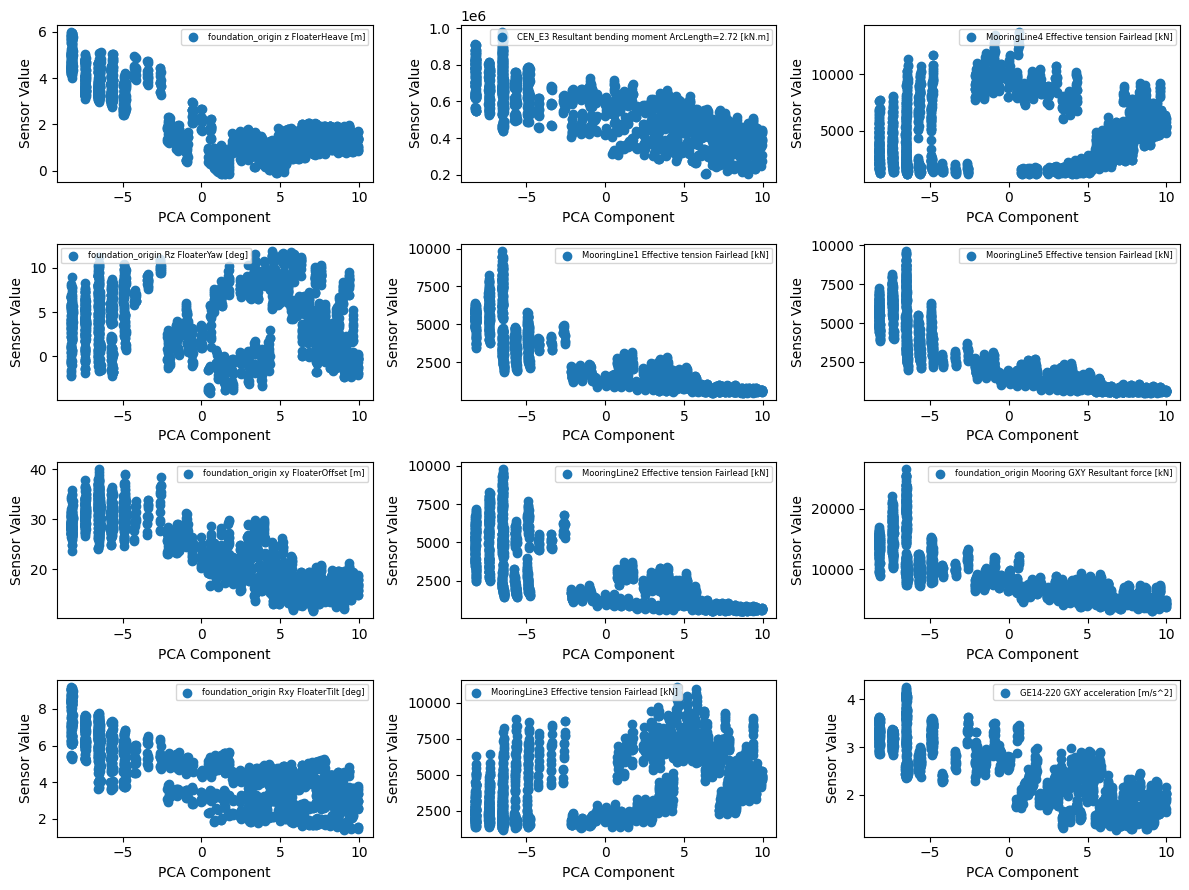

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
caselist_unique_pca = pca.fit_transform(caselist_unique)
print(pca.explained_variance_ratio_)
print(pd.DataFrame(caselist_unique_pca))
# Create a grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 9))

# Iterate over sensors
for i, sensor_id in enumerate(sensors['id']):
    # Get sensor name
    sensor_name = sensors.loc[sensors['id'] == sensor_id, 'name'].values[0]
    
    # Get sensor data from mean_results
    sensor_data = mean_results[sensor_id]
    
    # Calculate the row and column index for the subplot
    row = i % 4
    col = i // 4
    
    # Plot sensor data in a separate subplot
    axs[row, col].scatter(caselist_unique_pca, sensor_data, label=sensor_name)
    axs[row, col].set_xlabel('PCA Component')
    axs[row, col].set_ylabel('Sensor Value')
    axs[row, col].legend(fontsize=6)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()